In [1]:
# Import libraries
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import PIL
from tensorflow import keras
from keras.layers import *
from keras.models import *
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

## Load the data and visualise the images

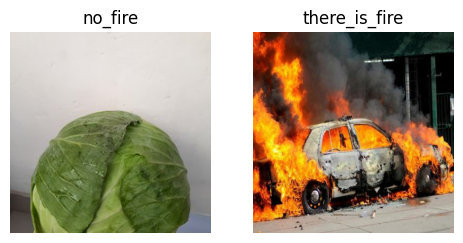

In [2]:
# Let's plot a few images
train_path = "fire_detection/train"
validation_path = "fire_detection/validation"
test_path = "fire_detection/test"

image_categories = os.listdir('fire_detection/train')

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 33327 files belonging to 2 classes.
Found 10930 files belonging to 2 classes.
Found 7791 files belonging to 2 classes.


In [4]:
# # Creating Image Data Generator for train, validation and test set

# # 1. Train Set
# train_gen = ImageDataGenerator(rescale = 1./255,
#                                       rotation_range=30,
#                                       width_shift_range=0.2,
#                                       height_shift_range=0.2,
#                                       shear_range=0.2,
#                                       zoom_range=0.2,
#                                       horizontal_flip=True,
#                                       fill_mode='nearest')

# train_image_generator = train_gen.flow_from_directory(
#                                             train_path,
#                                             target_size=(200, 200),
#                                             batch_size=32,
#                                             class_mode='binary')

# # 2. Validation Set
# val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
# val_image_generator = train_gen.flow_from_directory(
#                                             validation_path,
#                                             target_size=(200, 200),
#                                             batch_size=32,
#                                             class_mode='binary')

# # 3. Test Set
# test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
# test_image_generator = train_gen.flow_from_directory(
#                                             test_path,
#                                             target_size=(200, 200),
#                                             batch_size=32,
#                                             class_mode='binary')

In [5]:
# # Print the class encodings done by the generators
# class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
# print(class_map)

In [6]:
model= Sequential()
model.add(Conv2D(filters=64,activation="relu",kernel_size=3,input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, activation="relu",kernel_size=3))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, activation="relu",kernel_size=3))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, activation="relu",kernel_size=3))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=512, activation="relu"))
# jgn disini
model.add(Dense(units=1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=5, verbose=1, min_delta=1e-2)

In [8]:
train_data = train_data.repeat()
validation_data = validation_data.repeat()

In [9]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
    hist = model.fit(
        train_data,
        epochs=50,
        verbose=1,
        validation_data=validation_data,
        steps_per_epoch= 33327//32,
        validation_steps = 10930//32,
        callbacks= [early_stop,reduce_lr_on_plateau]
    )

Epoch 1/50
  32/1041 [..............................] - ETA: 25:48 - loss: 19.3348 - accuracy: 0.5312

KeyboardInterrupt: 

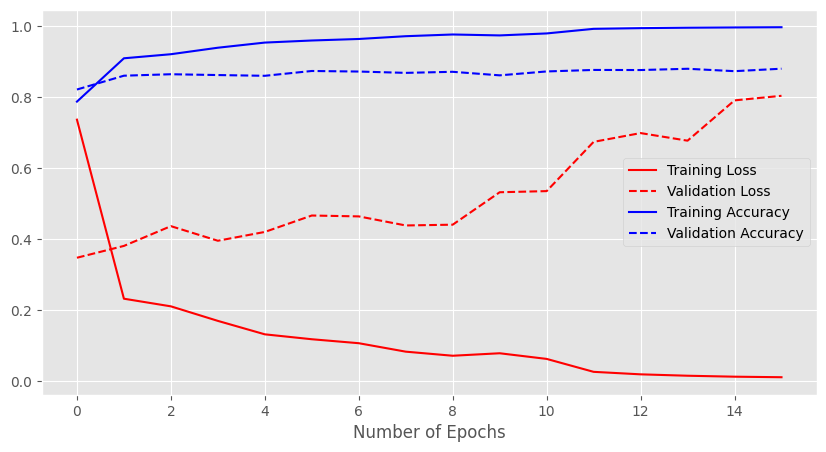

In [10]:
# Plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [11]:
def visualize_metrics(hist):
  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(hist.epoch, hist.history['loss'], label='Loss')
  plt.plot(hist.epoch, hist.history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(hist.epoch, hist.history['accuracy'], label='Acc')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

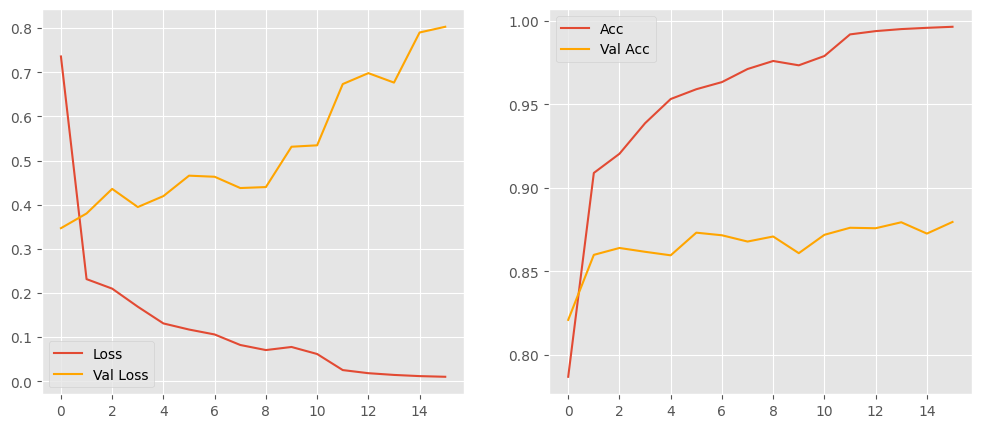

In [12]:
visualize_metrics(hist)

In [13]:
# Predict the accuracy for the test set
model.evaluate(test_data)


  1/244 [..............................] - ETA: 37s - loss: 0.5096 - accuracy: 0.8125

2023-05-16 09:21:43.006035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7791]
	 [[{{node Placeholder/_0}}]]
2023-05-16 09:21:43.009127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7791]
	 [[{{node Placeholder/_0}}]]


244/244 [==============================] - 6s 23ms/step - loss: 0.8808 - accuracy: 0.7989


[0.8808121085166931, 0.7988705039024353]

In [14]:
model.save("fire_model1.h5")
model.save_weights("fire_weight1.h5")

# Prediction

In [15]:
# Import libraries
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import PIL
from tensorflow import keras
from keras.layers import *
from keras.models import *
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [16]:
# model= Sequential()
# model.add(Conv2D(filters=64,activation="relu",kernel_size=3,input_shape=(150,150,3)))
# model.add(MaxPool2D(pool_size=2, strides=2))
# model.add(Conv2D(filters=64, activation="relu",kernel_size=3))
# model.add(MaxPool2D(pool_size=2, strides=2))
# model.add(Conv2D(filters=128, activation="relu",kernel_size=3))
# model.add(MaxPool2D(pool_size=2, strides=2))
# model.add(Conv2D(filters=128, activation="relu",kernel_size=3))
# model.add(MaxPool2D(pool_size=2, strides=2))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(units=512, activation="relu"))
# # jgn disini
# model.add(Dense(units=1,activation="sigmoid"))

# model.summary()

In [17]:
# Create a new model instance
# model = create_model()

# Load the previously saved weights
model.load_weights('fire_weight1.h5')

1/1 [==============================] - 0s 17ms/step
[[0.99820864]]
fire


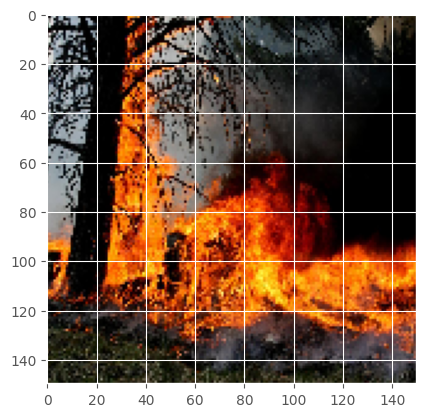

In [25]:
# predicting image with own model
import keras.utils as image
imx_path = "fire_detection/test/there_is_fire/fire.584.png"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 16ms/step
[[1.]]
fire


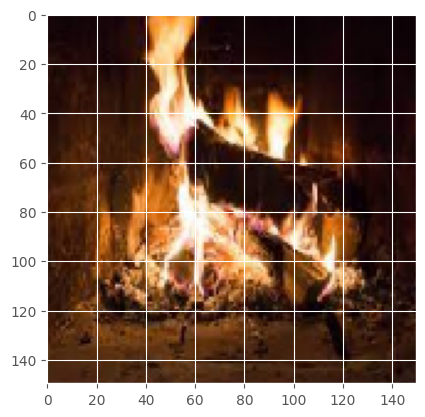

In [27]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest1.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 18ms/step
[[0.96387213]]
fire


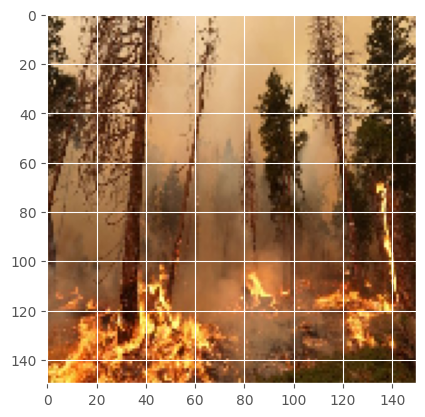

In [28]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest2.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 16ms/step
0.07626115
no fire


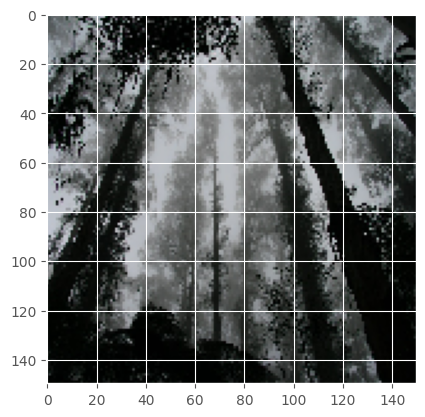

In [29]:
# predicting image with own model
import keras.utils as image
imx_path = "fire_detection/test/no_fire/non_fire.18.png"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result[0][0])
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 15ms/step
[[0.00034629]]
no fire


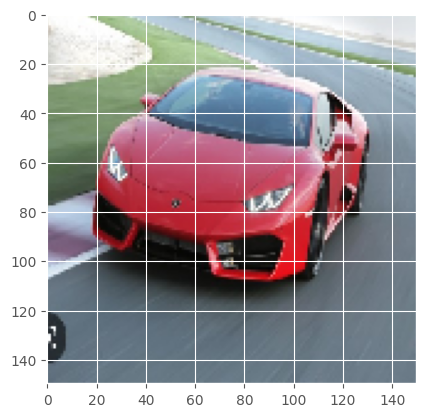

In [30]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest3.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 16ms/step
[[0.01117051]]
no fire


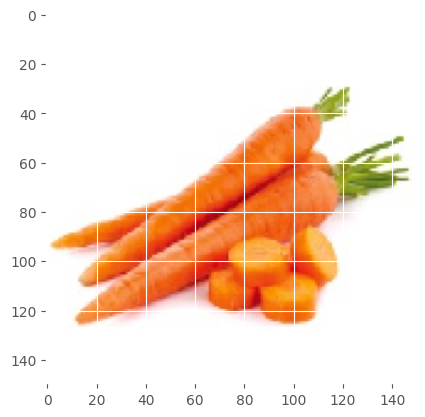

In [32]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest4.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 16ms/step
[[0.15756635]]
no fire


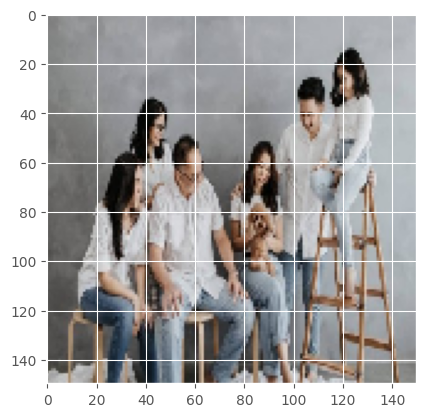

In [33]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest5.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 16ms/step
[[0.04820608]]
no fire


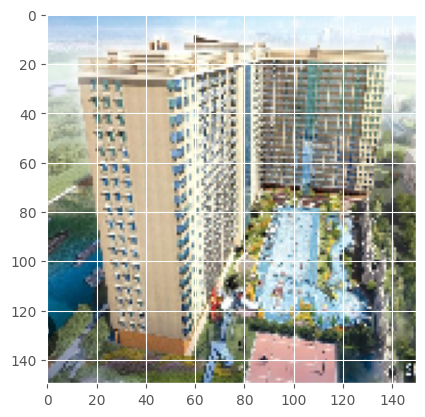

In [34]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest6.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

1/1 [==============================] - 0s 15ms/step
[[0.06884516]]
no fire


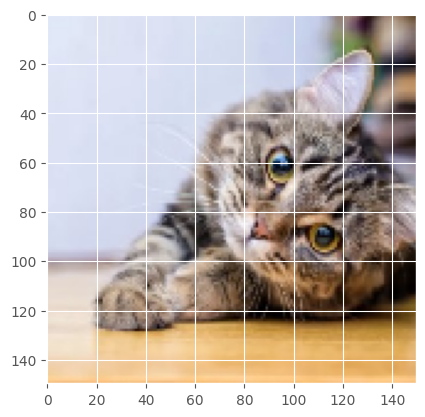

In [35]:
# predicting image with own model
import keras.utils as image
imx_path = "externtest7.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)

test_image = image.load_img(imx_path, target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] > 0.5:
    prediction = 'fire'
else:
    prediction = 'no fire'
print(prediction)

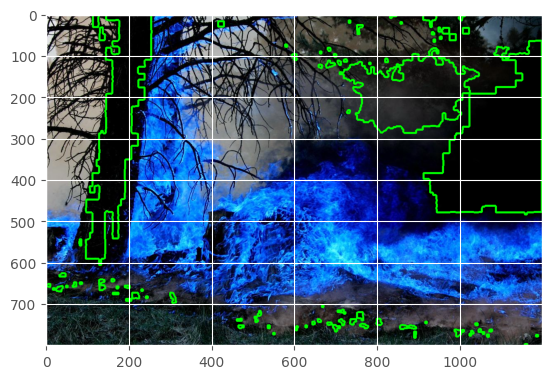

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("fire_detection/test/there_is_fire/fire.584.png")

# Define the lower and upper bounds for the color range of the fire
lower_fire = np.array([0, 0, 0])
upper_fire = np.array([255, 50, 50])

# Convert the image to the HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Create a mask using the lower and upper bounds for the fire color
mask = cv2.inRange(hsv, lower_fire, upper_fire)

# Apply a series of morphological transformations to the mask to remove noise and fill holes
kernel = np.ones((5,5),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask and draw them on the original image
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,255,0), 3)

# Display the original image and the mask
plt.imshow(img)

# # # Wait for a key press and then close all windows
# cv2.waitKey(0)
# cv2.destroyAllWindows()


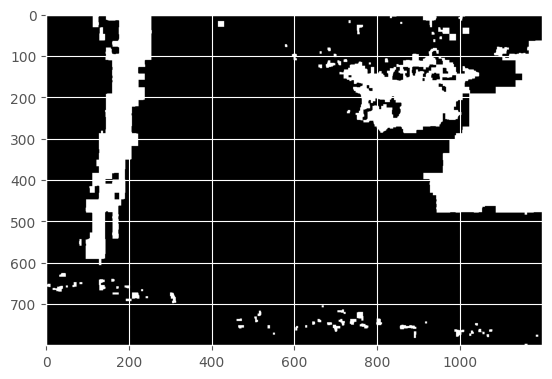

In [37]:
plt.imshow(mask, cmap="gray")

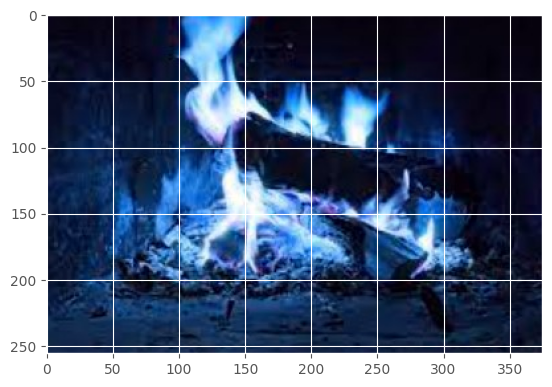

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("externtest1.jpg")

# Define the lower and upper bounds for the color range of the fire
lower_fire = np.array([0, 0, 200])
upper_fire = np.array([50, 50, 255])

# Convert the image to the HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Create a mask using the lower and upper bounds for the fire color
mask = cv2.inRange(hsv, lower_fire, upper_fire)

# Apply a series of morphological transformations to the mask to remove noise and fill holes
kernel = np.ones((5,5),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Create a binary image with white pixels for the fire and black pixels for the background
binary = np.zeros_like(img[:,:,0])
binary[mask == 255] = 255

# Display the original image and the binary image
plt.imshow(img)

# # Wait for a key press and then close all windows
# cv2.waitKey(0)
# cv2.destroyAllWindows()


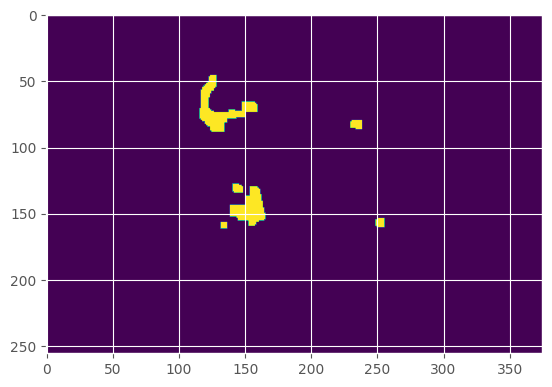

In [39]:
plt.imshow(binary)